In [1]:
#  Copyright 2022 Institute of Advanced Research in Artificial Intelligence (IARAI) GmbH.
#  IARAI licenses this file to You under the Apache License, Version 2.0
#  (the "License"); you may not use this file except in compliance with
#  the License. You may obtain a copy of the License at
#  http://www.apache.org/licenses/LICENSE-2.0
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.

In [2]:
import os
import sys
# Alternatevly, in order to make the module imports work properly set PYTHONPATH=$PWD before launching the notebook server from the repo root folder.
sys.path.insert(0, os.path.abspath("../"))  # noqa:E402

![t4c20logo](../t4c20logo.png)

In [3]:
import statistics
from collections import defaultdict

import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric
import tqdm
from IPython.core.display import HTML
from IPython.display import display
from torch import nn
from torch_geometric.nn import MessagePassing
from pathlib import Path
import numpy as np

import t4c22
from t4c22.metric.masked_crossentropy import get_weights_from_class_fractions
from t4c22.misc.t4c22_logging import t4c_apply_basic_logging_config
from t4c22.t4c22_config import class_fractions
from t4c22.t4c22_config import load_basedir
from t4c22.dataloading.t4c22_dataset_geometric import T4c22GeometricDataset
from t4c22.plotting.plot_congestion_classification import plot_segment_classifications_simple
from t4c22.misc.notebook_helpers import restartkernel  # noqa:F401

%matplotlib inline
%load_ext autoreload
%load_ext time
%autoreload 2
%autosave 60
display(HTML("<style>.container { width:80% !important; }</style>"))

The time module is not an IPython extension.


Autosaving every 60 seconds


In [22]:
t4c_apply_basic_logging_config(loglevel="DEBUG")
# load BASEDIR from file, change to your data root
BASEDIR = load_basedir(fn="t4c22_config.json", pkg=t4c22)
city = "london"
# city = "melbourne"
# city = "madrid"
dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("tmp/processed"), add_nearest_ctr_edge=True)
# train_dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("/tmp/processed5"), limit=1000)
dataset.get(0), len(dataset)

(Data(x=[59110, 6], edge_index=[2, 132414], y=[132414]), 7040)

In [5]:
# Writing data to cache
for data in tqdm.notebook.tqdm(torch_geometric.loader.dataloader.DataLoader(dataset, batch_size=16, shuffle=False, num_workers=16)):
    continue

  0%|          | 0/440 [00:00<?, ?it/s]

## Torch Geometric Dataset

In [6]:
spl = int(((0.8 * len(dataset)) // 2) * 2)
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [spl, len(dataset) - spl])
len(train_dataset), len(val_dataset)

(5632, 1408)

## Testing

In [7]:
@torch.no_grad()
def create_prediction(model, predictor):
    model.to(device)
    predictor.to(device)
    city_class_weights.to(device)
    loss_f = torch.nn.CrossEntropyLoss(weight=city_class_weights, ignore_index=-1, reduction="none")
    loss_f.to(device)
    dfs = []

    for idx, data in tqdm.notebook.tqdm(enumerate(dataset), total=len(dataset)):

        data.x = data.x.nan_to_num(-1)
        data = data.to(device)
        h = model(data)

        x_i = torch.index_select(h, 0, data.edge_index[0])
        x_j = torch.index_select(h, 0, data.edge_index[1])

        # logits
        y_hat = predictor(x_i, x_j)
        df = pd.DataFrame(torch.nn.functional.softmax(y_hat, dim=1).cpu().numpy(), columns=["0", "1", "2"])
        # print(data.y.cpu().numpy())
        df["y"] = data.y.nan_to_num(0).cpu().numpy()
        df["y_hat"] = df[["0", "1", "2"]].idxmax(axis=1).astype("int64")
        dfs.append(df)

    return dfs

In [8]:
city_class_fractions = class_fractions[city]
city_class_fractions

{'green': 0.5367906303432076,
 'yellow': 0.35138063340805714,
 'red': 0.11182873624873524}

In [9]:
city_class_weights = get_weights_from_class_fractions([city_class_fractions[c] for c in ["green", "yellow", "red"]])
# city_class_weights.append(0.1) # weight for no data
city_class_weights = torch.tensor(city_class_weights).float()
city_class_weights

tensor([0.6210, 0.9486, 2.9807])

## Looking into London samples

In [23]:

t4c_apply_basic_logging_config(loglevel="INFO")
city = "london"
# Monday
day = "2019-07-01"
# load BASEDIR from file, change to your data root
BASEDIR = load_basedir(fn="t4c22_config.json", pkg=t4c22)
dataset = T4c22GeometricDataset(root=BASEDIR, city=city, split="train", cachedir=Path("tmp/processed"), add_nearest_ctr_edge=True, day_t_filter=lambda _day, t: _day == day)
len(dataset)

92

In [19]:
from GNN_model import CongestioNN
from GNN_model import LinkPredictor
import json

epochs = 1

device = 1
device = f"cuda:{device}" if torch.cuda.is_available() else "cpu"
device = torch.device(device)


with open("model_parameters.json", "r") as f:
    model_parameters = json.load(f)

model = CongestioNN(**model_parameters["GNN"])
model.load_state_dict(torch.load(f"GNN_model_{epochs:03d}.pt", map_location=device))

predictor = LinkPredictor(**model_parameters["Predictor"])
predictor.load_state_dict(torch.load(f"GNN_predictor_{epochs:03d}.pt", map_location=device))

<All keys matched successfully>

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

df = create_prediction(model, predictor)
df = pd.concat(df).reset_index(drop=True)

  0%|          | 0/100 [00:00<?, ?it/s]

FileNotFoundError: /scratch/t4c22/public_data/withheld/golden/london/labels/cc_labels_test.parquet

In [13]:
df

,0,1,2,y,y_hat
0,0.662852,0.164225,0.172923,0.0,0
1,0.862507,0.074389,0.063104,0.0,0
2,0.986035,0.007004,0.006961,0.0,0
3,0.989510,0.005307,0.005183,0.0,0
4,0.737845,0.131318,0.130837,0.0,0
...,...,...,...,...,...
16830272,0.859952,0.075716,0.064332,0.0,0
16830273,0.746617,0.129144,0.124239,0.0,0
16830274,0.758886,0.120624,0.120490,0.0,0
16830275,0.980806,0.009597,0.009596,0.0,0


<AxesSubplot:xlabel='2', ylabel='Count'>

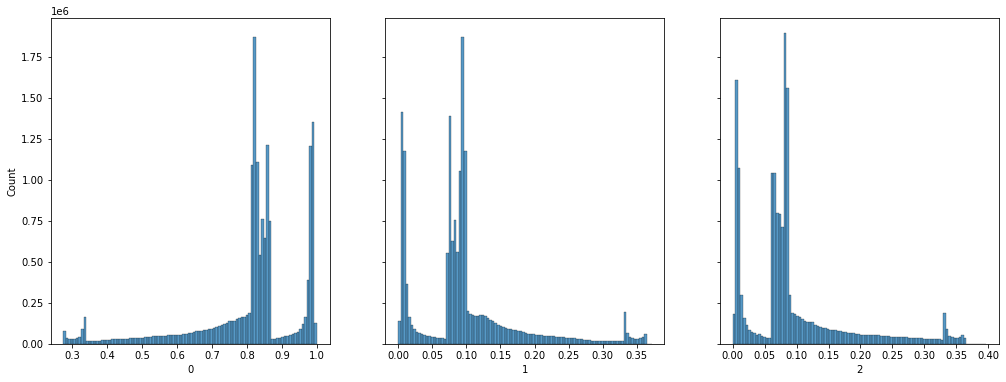

In [17]:
fig, axs = plt.subplots(ncols=3, figsize=(17, 6), sharey=True)
bins = 100
sns.histplot(data=df, x="0", bins=bins, ax=axs[0])
sns.histplot(data=df, x="1", bins=bins, ax=axs[1])
sns.histplot(data=df, x="2", bins=bins, ax=axs[2])
# sns.histplot(data=df, x="3", bins=bins, ax=axs[3])

In [15]:
from sklearn.metrics import confusion_matrix

confm = confusion_matrix(df["y"], df["y_hat"], normalize="true")

[2022-08-17 14:33:18,803][DEBUG][51870][colorbar.py:_get_ticker_locator_formatter:871] locator: <matplotlib.ticker.AutoLocator object at 0x7eff232b5580>


[Text(0.5, 15.0, 'Prediction'), Text(33.0, 0.5, 'True Label')]

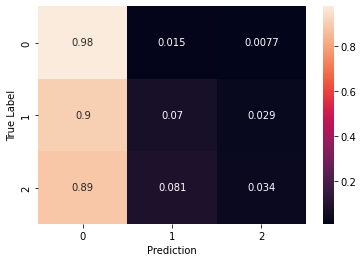

In [16]:
ax = sns.heatmap(confm, annot=True)
ax.set(xlabel='Prediction', ylabel='True Label')